In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
%matplotlib inline
import torch
from deepseries.models import WaveNet, init
from deepseries.dataset import Property, TimeSeries, Seq2SeqDataLoader
from deepseries.nn.loss import MSELoss, RMSELoss
from deepseries.train import Learner
from torch.optim import Adam
from torch import nn
import matplotlib as mpl
from sklearn.metrics import mean_absolute_error
import chinese_calendar as calendar
import datetime as dt
info = pd.read_excel("./data/info.xlsx")
recored = info.set_index("contributor_id")['huangzf']
info = pd.read_excel("./data/info.xlsx").set_index("contributor_id")[['pjt_name', 'pjt_type']]
norm_score = pd.read_csv(r"C:\Users\evilp\project\Deep-Time-Series-Prediction\data\20200315_20200415.csv")

In [2]:
power = pd.read_csv('./data/df.csv', parse_dates=['data_time'])[['data_time', 'cid', 'value']]
power = power.set_index("data_time").groupby("cid").resample("1H").sum().reset_index()
power = power.pivot(index='cid', columns='data_time', values='value')
power = power.apply(np.log1p).iloc[:, 10000:]

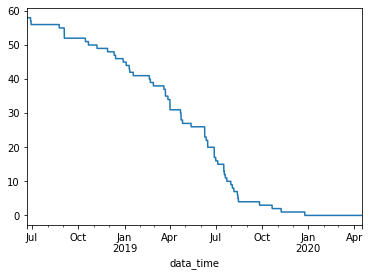

In [3]:
power.isnull().sum().plot()

In [4]:
is_zero = power.values == 0
is_nan = power.isnull().values
is_valid = ~is_zero & ~is_nan

xy = np.ma.masked_array(power.values, mask=~is_valid)

series_mu = xy.mean(axis=1).data.reshape(-1, 1)
series_std = xy.std(axis=1).data.reshape(-1, 1)
xy = (xy - series_mu) / series_std
xy = xy.filled(0.)

xy = np.expand_dims(xy, 1).astype('float32')

N_TEST = 24 * 30
N_VALID = 24 * 2
DROP_ZERO = True
DEC_LEN = 24 * 2
ENC_LEN = 24 * 7
time_free_space = 24

In [5]:
def n_lag(series, n):
    lag = np.zeros_like(series)
    lag[:, :, n:] = series[:, :, :-n]
    return lag

x_lag7 = n_lag(xy, 7 * 24)
x_lag14 = n_lag(xy, 14 * 24)

x_is_valid = np.expand_dims(is_valid, 1)

x_num_features = np.concatenate([x_lag7, x_lag14, x_is_valid], axis=1).astype("float32")

weights = x_is_valid.astype("float32") + 1e-6

In [6]:
def periodic_feature(x, T):
    psin = np.sin(x * np.pi * 2 / T)
    pcos = np.cos(x * np.pi * 2 / T)
    return np.stack([psin, pcos], axis=0)


xy_weekday = np.repeat(
    np.expand_dims(
        periodic_feature(power.columns.weekday.values, 7), axis=0), xy.shape[0], axis=0)

xy_hour = np.repeat(
    np.expand_dims(
        periodic_feature(power.columns.hour.values, 24), axis=0), xy.shape[0], axis=0)

xy_month = np.repeat(
    np.expand_dims(
        periodic_feature(power.columns.month.values, 12), axis=0), xy.shape[0], axis=0)

def get_holiday_features(dts):
    holidays = pd.get_dummies(pd.Series(dts).apply(lambda x: calendar.get_holiday_detail(x)[1]))
    holidays['sick'] = np.where((power.columns >= "2020-02-01") & (power.columns < "2020-03-01"), 1, 0)
    return holidays

holidays = get_holiday_features(power.columns)
holidays = np.expand_dims(holidays.values.transpose(1, 0), 0)
holidays = np.repeat(holidays, xy.shape[0], axis=0)

xy_num_features = np.concatenate([
    xy_weekday,
    xy_hour,
    xy_month,
    holidays
], axis=1).astype('float32')

In [7]:
class ForwardSpliter:
    
    def split(self, time_idx, enc_len, dec_len, valid_size):
        if valid_size < 1:
            valid_size = int(np.floor(len(time_idx) * valid_size))
        valid_idx = time_idx[-(valid_size+enc_len):]
        train_idx = time_idx[:-valid_size]
        return train_idx, valid_idx
    
spliter = ForwardSpliter()
train_idx, valid_idx = spliter.split(np.arange(xy.shape[2]), ENC_LEN, DEC_LEN, N_TEST+N_VALID)
valid_idx, test_idx = spliter.split(valid_idx, ENC_LEN, DEC_LEN, N_TEST)

train_xy = TimeSeries(xy[:, :, train_idx])
valid_xy = TimeSeries(xy[:, :, valid_idx])

train_xy_features = TimeSeries(xy_num_features[:, :, train_idx])
valid_xy_features = TimeSeries(xy_num_features[:, :, valid_idx])

train_x_features = TimeSeries(x_num_features[:, :, train_idx])
valid_x_features = TimeSeries(x_num_features[:, :, valid_idx])

train_weight = TimeSeries(weights[:, :, train_idx])
valid_weight = TimeSeries(weights[:, :, valid_idx])

train_frame = Seq2SeqDataLoader(train_xy, batch_size=16, enc_lens=ENC_LEN, dec_lens=DEC_LEN, use_cuda=True, mode='train', time_free_space=24,
                          enc_num_feats=[train_xy_features, train_x_features], dec_num_feats=[train_xy_features], weight=train_weight)
valid_frame = Seq2SeqDataLoader(valid_xy, batch_size=64, enc_lens=ENC_LEN, dec_lens=DEC_LEN, use_cuda=True, mode='train', time_free_space=0,
                         time_interval=48, enc_num_feats=[valid_xy_features, valid_x_features], dec_num_feats=[valid_xy_features],
                               weight=valid_weight)

test_xy = xy[:, :, test_idx]
test_xf = np.concatenate([xy_num_features[:, :, test_idx], x_num_features[:, :, test_idx]], axis=1)
test_yf = xy_num_features[:, :, test_idx]

In [8]:
for batch in train_frame:
    print(batch[0]['enc_x'].shape)

torch.Size([16, 1, 178])
torch.Size([16, 1, 179])
torch.Size([16, 1, 145])
torch.Size([14, 1, 185])


In [9]:
for batch in valid_frame:
    print(batch[0]['enc_x'].shape)

torch.Size([62, 1, 168])


In [ ]:
model = WaveNet(enc_numerical=9+8, dec_numerical=6+8, dilations=[2 ** i for i in range(8)] * 3, 
                kernels_size=[2 for i in range(8)] * 3, dropout=0.5)
opt = Adam(model.parameters(), 0.002)
loss_fn = MSELoss()
model.cuda()
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, 32, 0.0005)
learner = Learner(model, opt, loss_fn, './power_env', log_interval=5000, lr_scheduler=lr_scheduler)
learner.fit(500, train_frame, valid_frame, patient=64, start_save=1, early_stopping=False)

start training >>>>>>>>>>>  see log: tensorboard --logdir ./power_env\logs
epoch 1 / 500, batch 100%, train loss 0.2035, valid loss 0.8468, cost time 0.3 minute
epoch 2 / 500, batch 100%, train loss 1.3637, valid loss 0.8198, cost time 0.3 minute
epoch 3 / 500, batch 100%, train loss 0.5572, valid loss 0.8549, cost time 0.2 minute
epoch 4 / 500, batch 100%, train loss 0.5144, valid loss 0.9158, cost time 0.3 minute
epoch 5 / 500, batch 100%, train loss 0.5004, valid loss 0.9156, cost time 0.3 minute
epoch 6 / 500, batch 100%, train loss 0.4103, valid loss 0.8619, cost time 0.3 minute
epoch 7 / 500, batch 100%, train loss 0.9928, valid loss 0.8276, cost time 0.3 minute
epoch 8 / 500, batch 100%, train loss 0.2140, valid loss 0.8131, cost time 0.3 minute
epoch 9 / 500, batch 100%, train loss 0.5346, valid loss 0.8146, cost time 0.3 minute
epoch 10 / 500, batch 100%, train loss 0.4730, valid loss 0.8191, cost time 0.2 minute
epoch 11 / 500, batch 100%, train loss 0.3283, valid loss 0.8196

In [11]:
test_xy = torch.as_tensor(xy[:, :, test_idx]).cuda()
test_xf = torch.as_tensor(np.concatenate([xy_num_features[:, :, test_idx], x_num_features[:, :, test_idx]], axis=1)).cuda()
test_yf = torch.as_tensor(xy_num_features[:, :, test_idx]).cuda()

In [12]:
def plot(x_true, y_true, y_pred):
    enc_ticks = np.arange(x_true.shape[1])
    dec_ticks = np.arange(y_pred.shape[1]) + x_true.shape[1]
    for idx, name in enumerate(power.index):
        plt.figure(figsize=(12, 3))
        plt.plot(enc_ticks, x_true[idx])
        plt.plot(dec_ticks, y_pred[idx], label='pred')
        plt.plot(dec_ticks, y_true[idx], label='true')
        plt.title(name)
        plt.legend()

def wmape(y_hat, y):
    scores = []
    for day in range(int(y.shape[0] / 24)):
        scores.append(np.abs(y[day*24: (day+1)*24] - y_hat[day*24: (day+1)*24]).sum() / np.sum(y[day*24: (day+1)*24]))
    return scores

def metric(y_true, y_pred):
    scores = {}
    for idx, name in enumerate(power.index):
        scores[name] = wmape(y_pred[idx], y_true[idx])
    return pd.DataFrame(scores)

def wmape_dataframe(y_hat, y):
    scores = []
    for day in range(int(y.shape[0] / 96)):
        scores.append(np.abs(y[day*96: (day+1)*96] - y_hat[day*96: (day+1)*96]).sum() / np.sum(y[day*96: (day+1)*96]))
    return scores

def metric_dataframe(y_true, y_pred):
    scores = {}
    for idx, name in enumerate(power.index):
        scores[name] = wmape_dataframe(y_pred.iloc[idx], y_true.iloc[idx])
    return pd.DataFrame(scores)

def predict(learner, xy, x_feats, y_feats, epoch):
    learner.load(rf"C:\Users\evilp\project\Deep-Time-Series-Prediction\power_env\checkpoints\model-epoch-{epoch}.pkl")
    learner.model.eval()
    learner.model.cuda()
    preds = []
    days = int(xy.shape[2] / 24 - ENC_LEN / 24 - DEC_LEN/24 + 1)
    for day in range(days):
        step = day * 24
#         enc_start = day
#         enc_end = (step+ENC_LEN) / 24
#         dec_start = enc_end
#         dec_end = (step+ENC_LEN+DEC_LEN) / 24
#         print(f"start {enc_start}, end {int(dec_end)}" )
        step_pred = model(
            xy[:, :, step: step+ENC_LEN], 
            enc_num=x_feats[:, :, step: step+ENC_LEN],
            dec_num=y_feats[:, :, step+ENC_LEN: step+ENC_LEN+DEC_LEN], dec_len=DEC_LEN).cpu().detach().numpy()
        if step == 0:
            preds.append(step_pred)
        else:
            preds.append(step_pred[:, :, -24:])
    preds = np.concatenate(preds, axis=2)
    preds = np.expm1(preds.squeeze() * series_std + series_mu)
    
    x_true = np.expm1(xy[:, :, :ENC_LEN].cpu().numpy().squeeze() * series_std + series_mu)
    y_true = np.expm1(xy[:, :, ENC_LEN:].cpu().numpy().squeeze() * series_std + series_mu)
    
    return x_true, y_true, preds

In [13]:
norm_data = pd.read_csv(r"C:\Users\evilp\project\Deep-Time-Series-Prediction\data\20200315_20200415.csv")
norm_true = norm_data.drop(['Unnamed: 0', 'model_name'], axis=1).pivot(index='contributor_id', columns='data_time', values='value')
norm_pred = norm_data.drop(['Unnamed: 0', 'model_name'], axis=1).pivot(index='contributor_id', columns='data_time', values='forecast_pwr')
norm_score = metric_dataframe(norm_true, norm_pred).mean()

x_true, y_true, y_pred  = predict(learner, test_xy, test_xf, test_yf, 30)
# r = y_true.mean() / y_pred.mean()
# y_pred = y_pred * r
scores = pd.DataFrame([metric(y_true, y_pred).mean().rename("wave"), norm_score.rename("normal")]).T.dropna()

C:\Users\evilp\AppData\Local\Continuum\anaconda3\envs\dl\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars


In [14]:
scores.merge(info, left_index=True, right_index=True)

wave    normal  \
91E0B6DC00B41783E0530BC8100A0E30  0.464779  0.071404   
91E0B6DC00B51783E0530BC8100A0E30  0.634663  0.075601   
91E0B6DC00B91783E0530BC8100A0E30  0.331014  0.072971   
91E0B6DC00BA1783E0530BC8100A0E30  0.272013  0.682333   
91E0B6DC00BB1783E0530BC8100A0E30  0.670961  0.345540   
...                                    ...       ...   
91E0C8BAA1C5259EE0530BC8100AFFB2  0.516772  0.125160   
91E0C8BAA1CB259EE0530BC8100AFFB2  0.323859  0.146927   
91E1E413742C0582E0530BC8100A3E6E  0.469626  0.405207   
9795AE222D56386FE0530BC8100A7150  0.573832  0.154277   
9AC089DEFCF45804E0530BC8100A23FC  0.175410  0.900409   

                                                   pjt_name pjt_type  
91E0B6DC00B41783E0530BC8100A0E30                    成都来福士广场       商业  
91E0B6DC00B51783E0530BC8100A0E30                  成都凯德广场·金牛       商业  
91E0B6DC00B91783E0530BC8100A0E30                     泸州长江机械       工业  
91E0B6DC00BA1783E0530BC8100A0E30                       万国数据       商业  
91E0B6DC00BB1783E0530BC8100A0E30                      成都王府井       商业  
...                                                     ...      ...  
91E0C8BAA1C5259EE0530BC8100AFFB2                     嘉宇商业管理       商业  
91E0C8BAA1CB259EE0530BC8100AFFB2                   四川仁寿金利纺织       工业  
91E1E413742C0582E0530BC8100A3E6E                  成都禅德太阳能电力       工业  
9795AE222D56386FE0530BC8100A7150                   四川西菱动力部件       工业  
9AC089DEFCF45804E0530BC8100A23FC  攀枝花煤业（集团）有限责任公司2832509016       工业  

[61 rows x 4 columns]

In [15]:
scores.merge(info, left_index=True, right_index=True).describe()

wave     normal
count  61.000000  61.000000
mean    0.754302   0.502023
std     1.526363   1.858010
min     0.047528   0.019034
25%     0.331014   0.099839
50%     0.544354   0.165167
75%     0.676091   0.362602
max    12.075146  14.635655

C:\Users\evilp\AppData\Local\Continuum\anaconda3\envs\dl\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


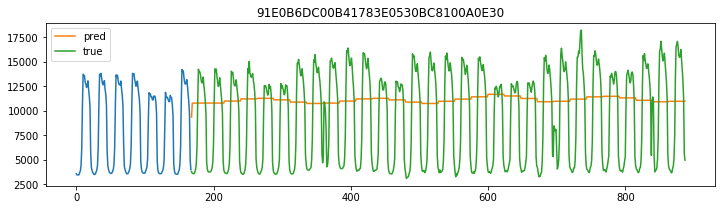

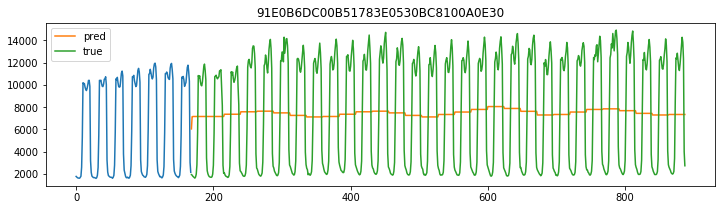

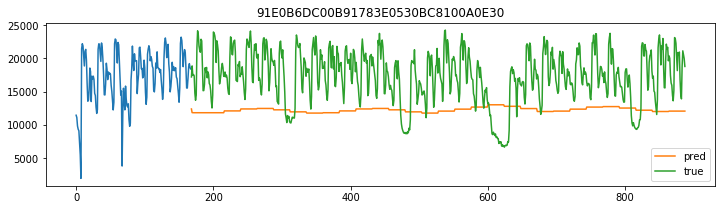

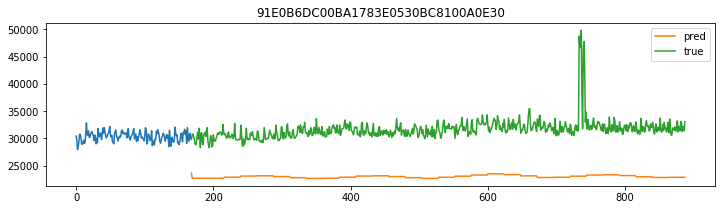

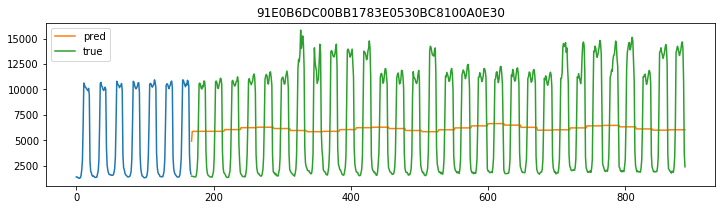

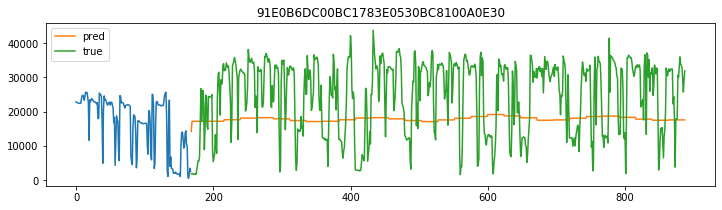

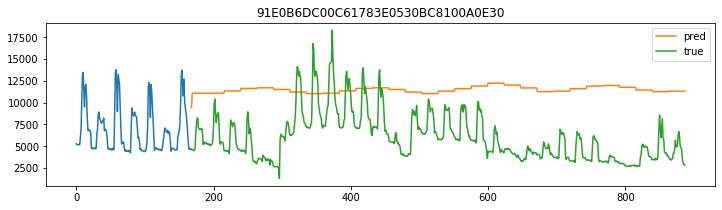

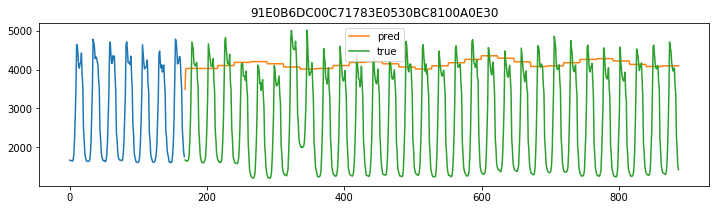

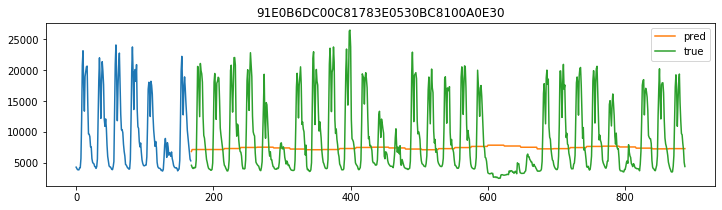

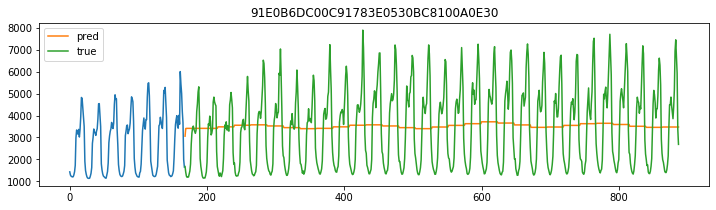

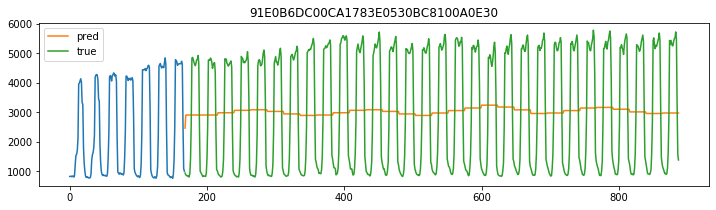

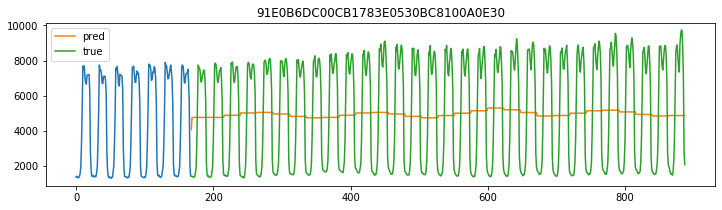

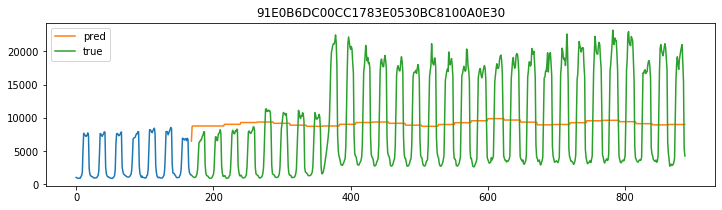

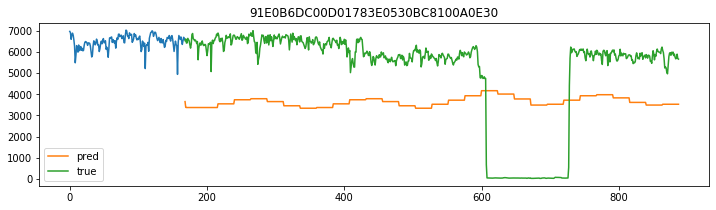

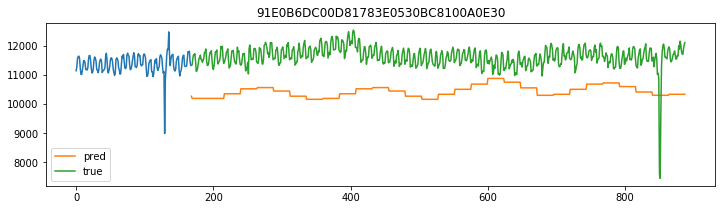

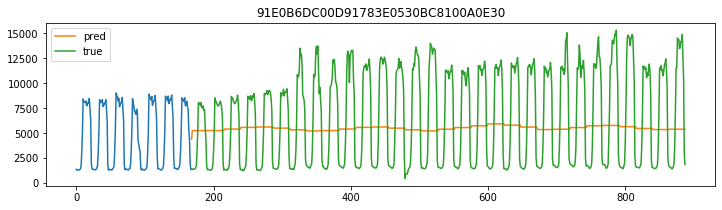

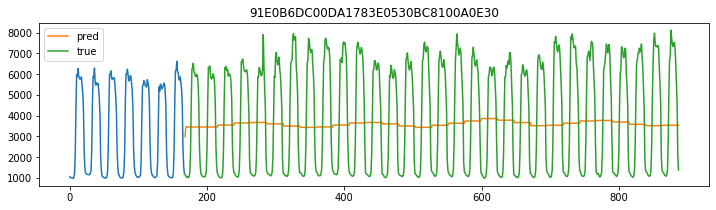

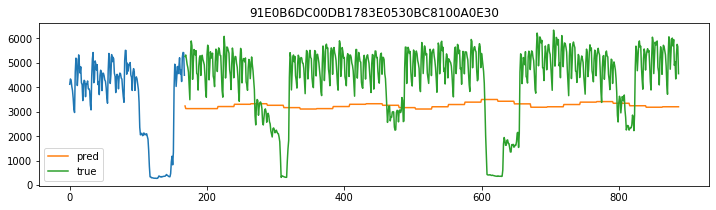

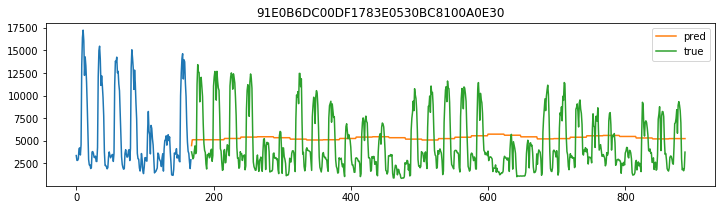

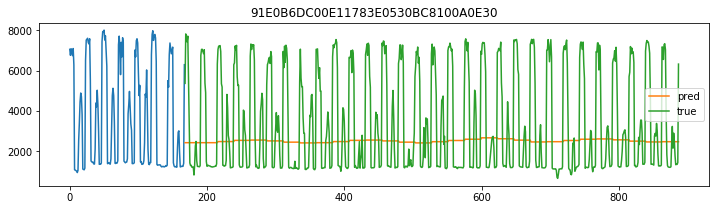

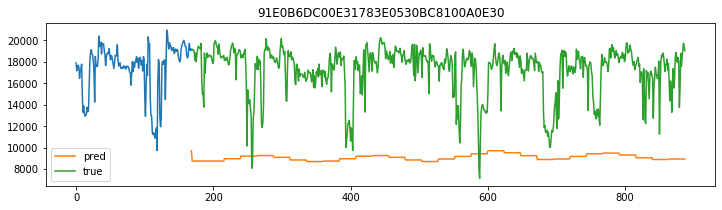

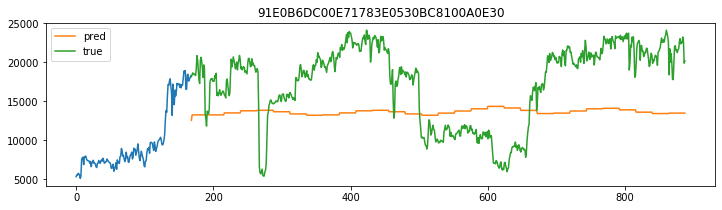

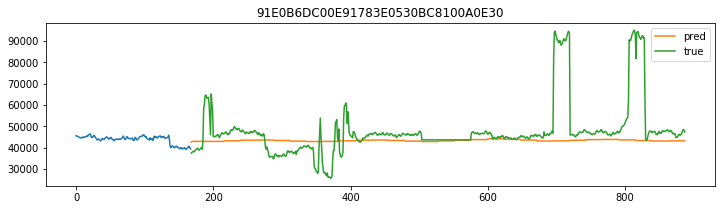

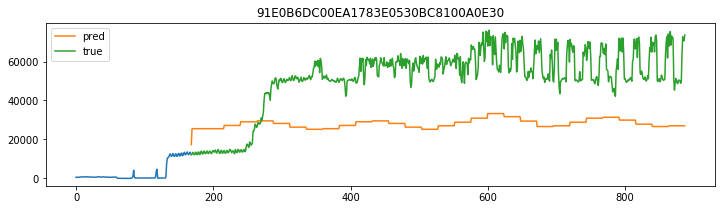

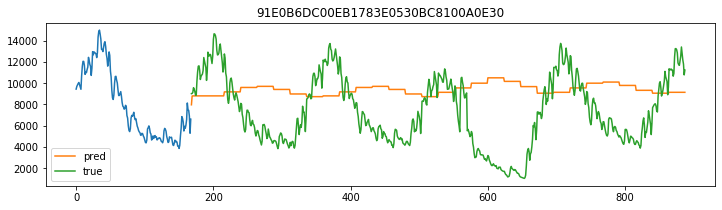

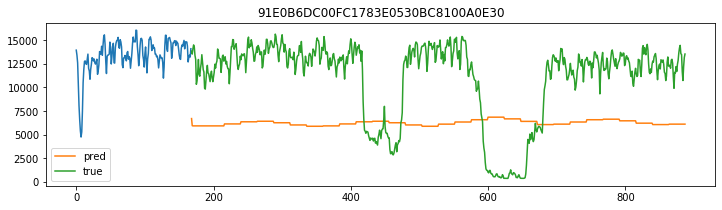

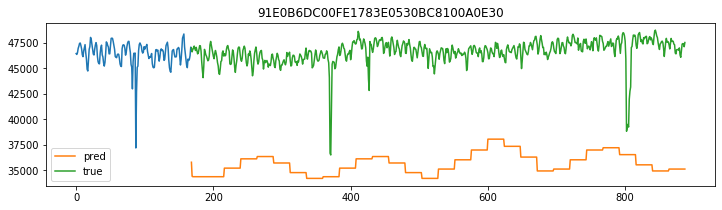

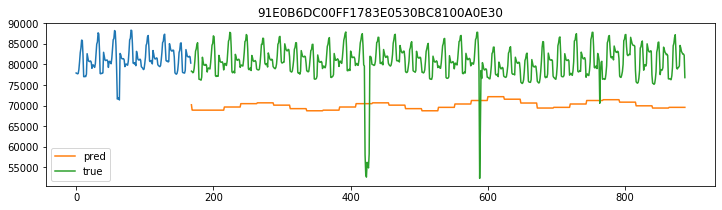

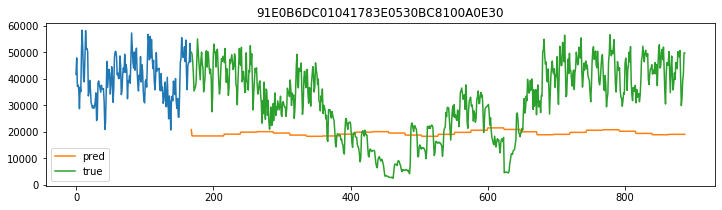

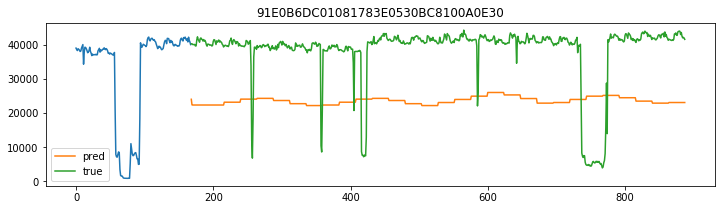

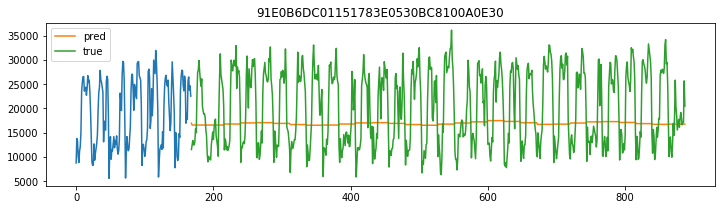

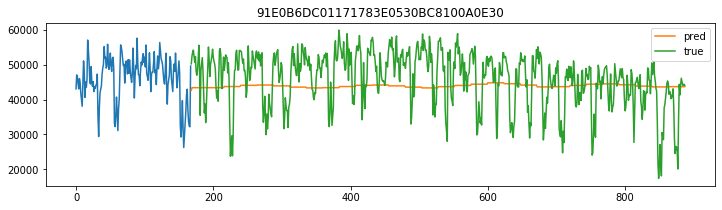

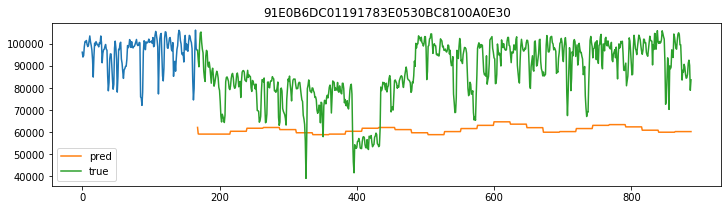

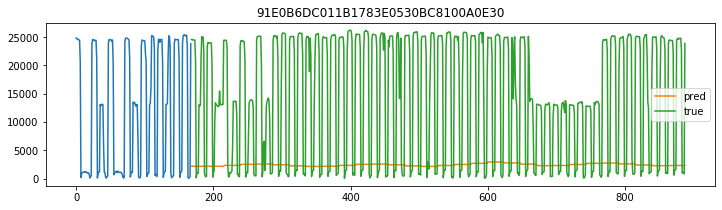

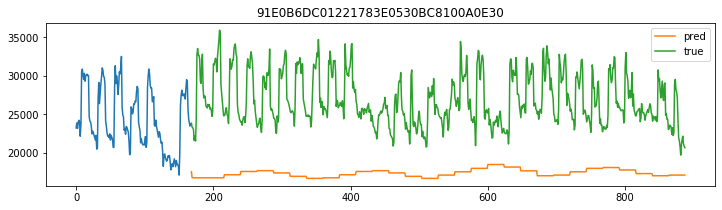

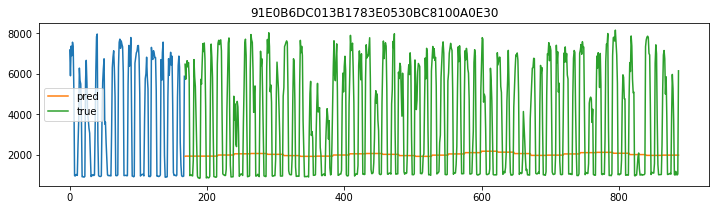

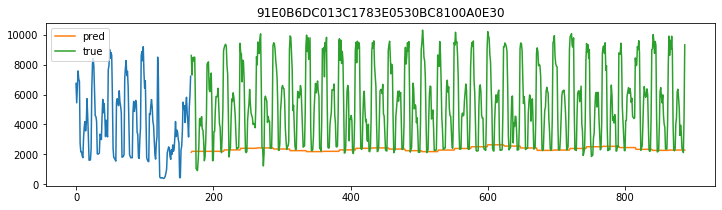

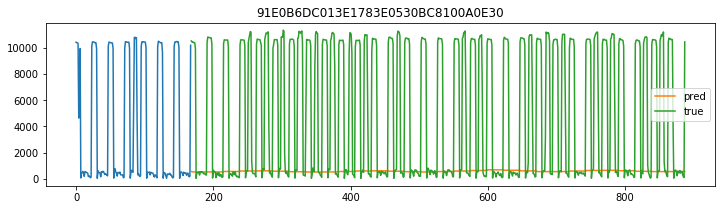

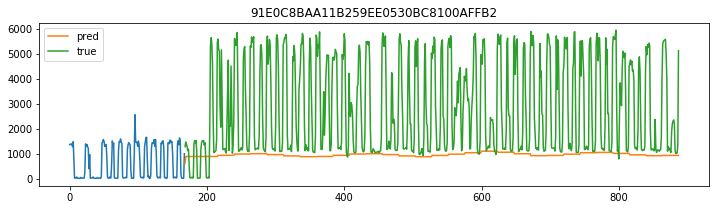

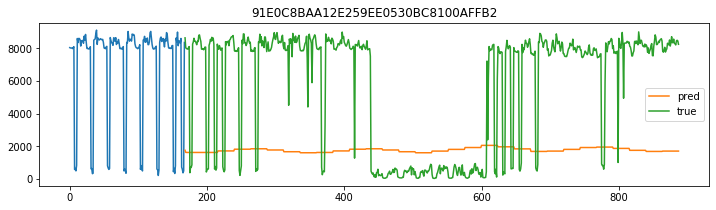

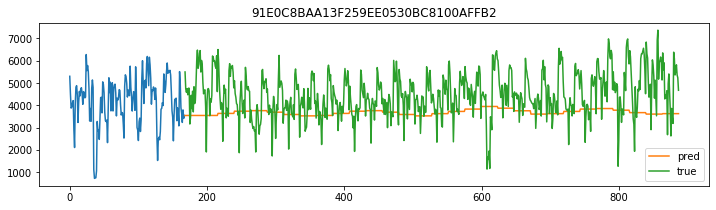

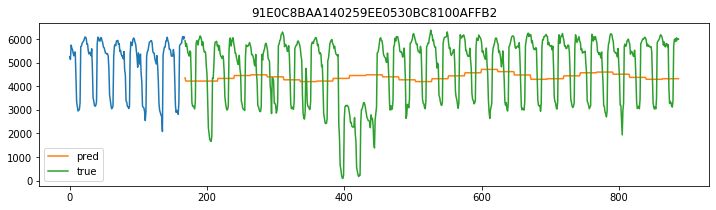

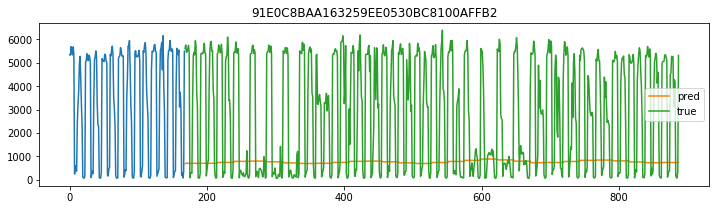

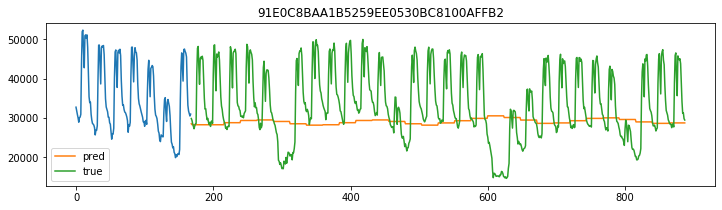

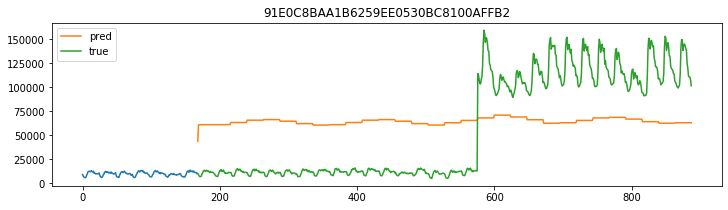

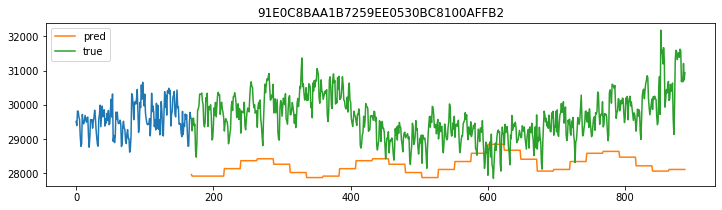

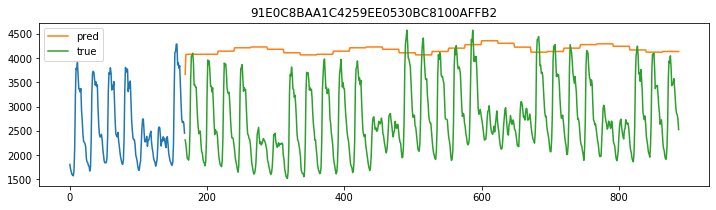

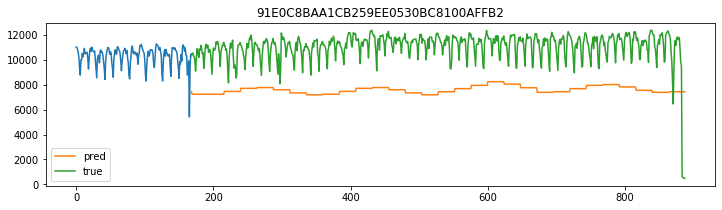

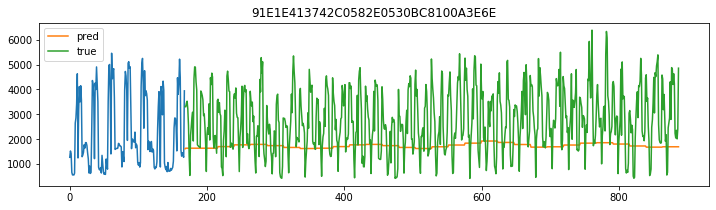

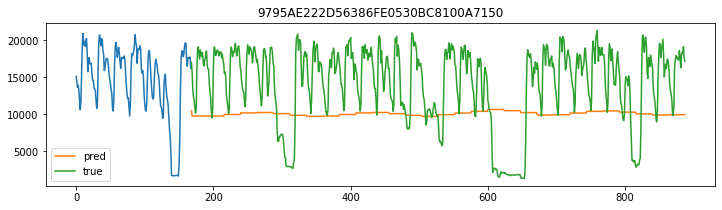

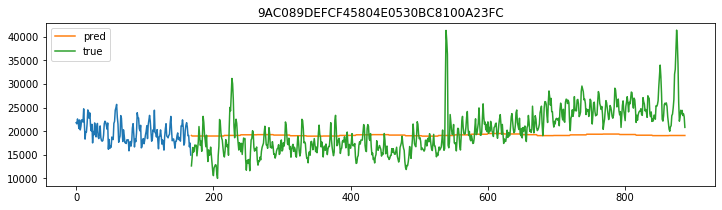

In [16]:
plot(x_true, y_true, y_pred)

/home/zhouzr/anaconda3/envs/pytorch_1.3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


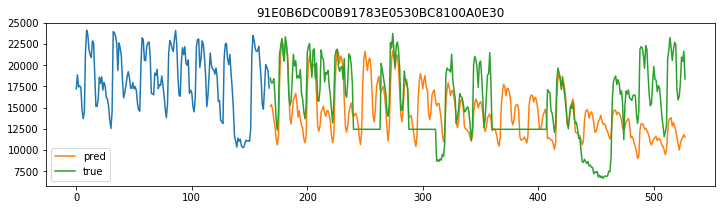

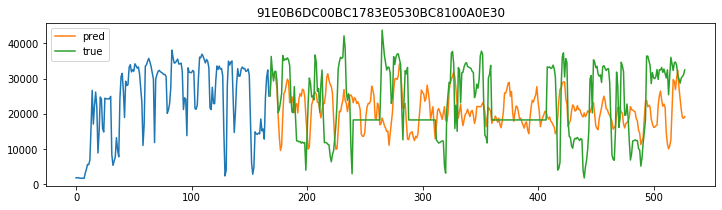

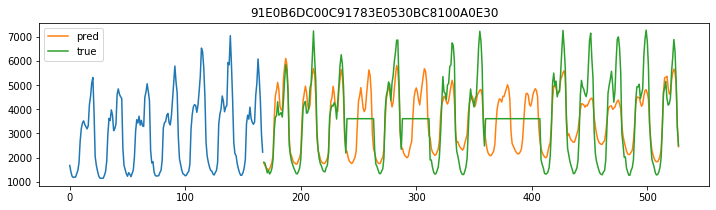

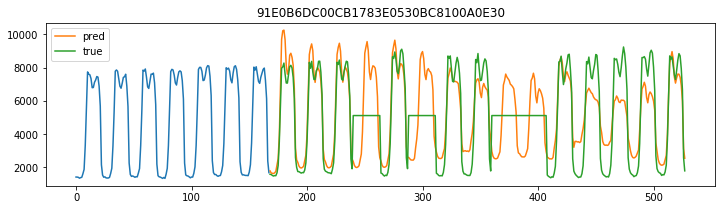

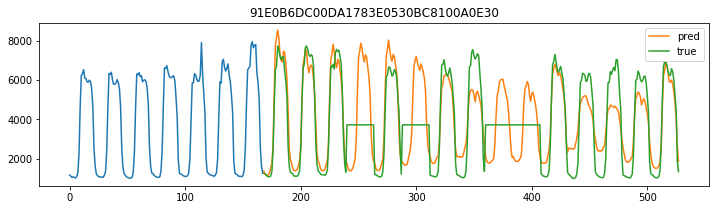

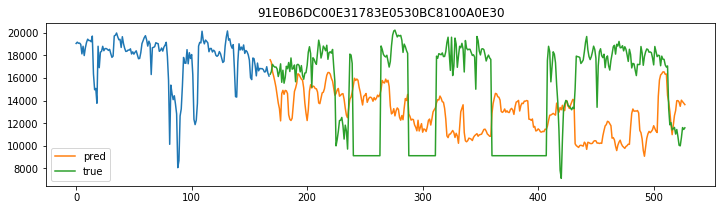

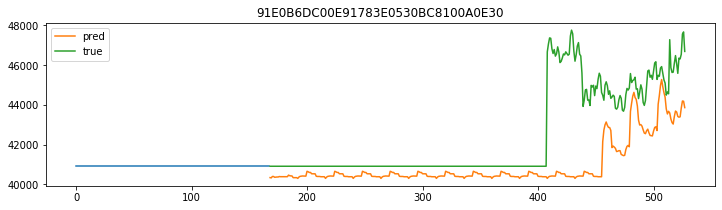

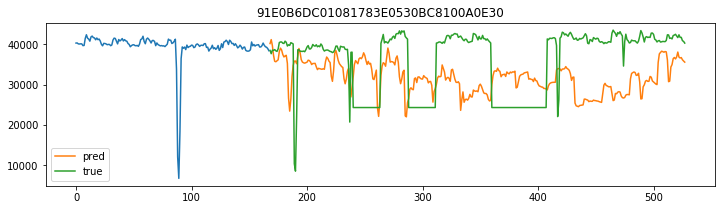

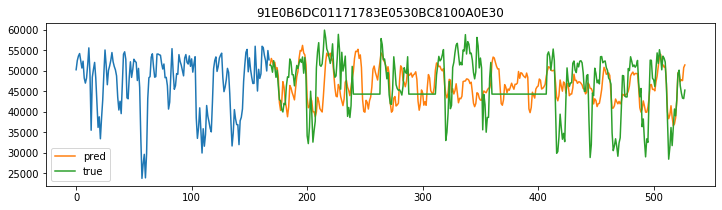

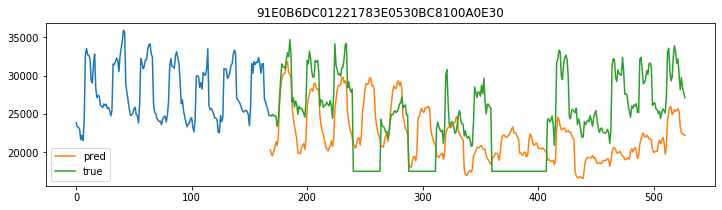

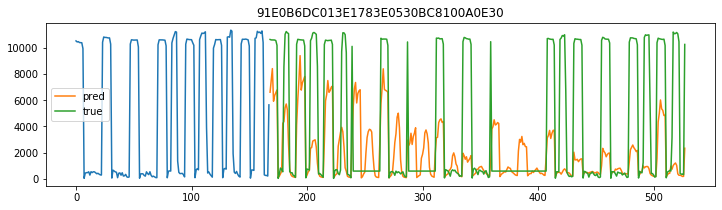

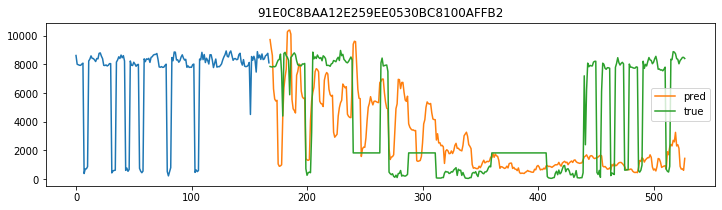

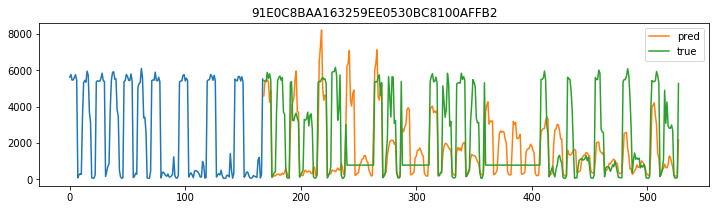

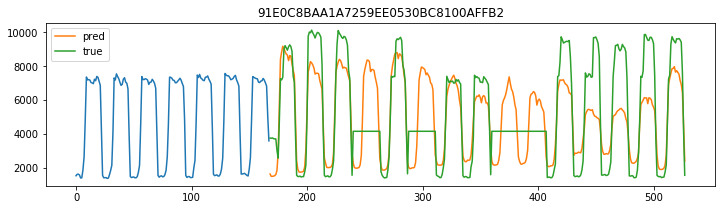

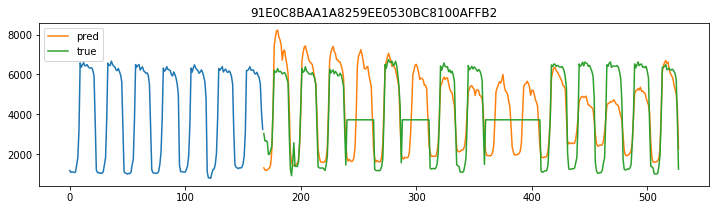

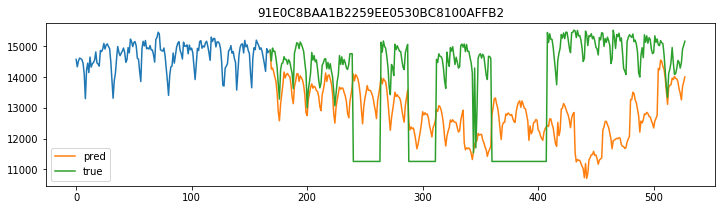

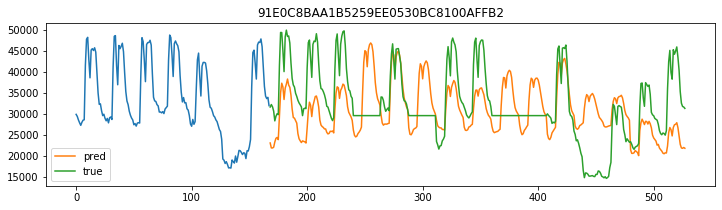

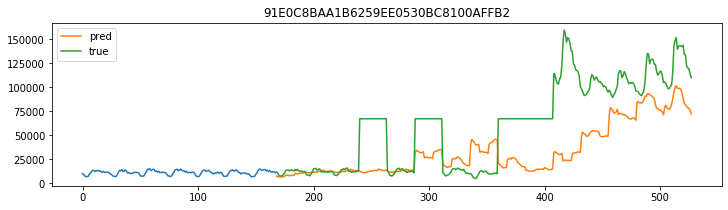

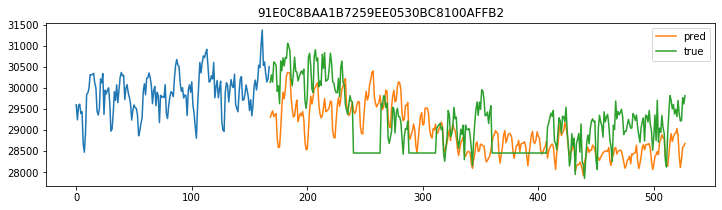

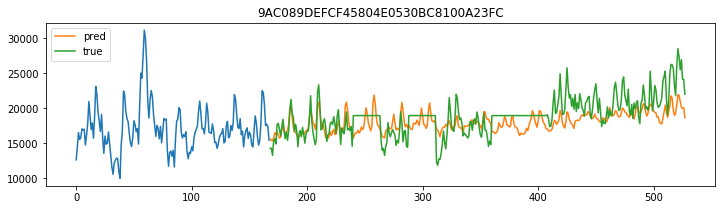

In [13]:
plot(x_true, y_true, y_pred)